In [2]:
import sqlite3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
con = sqlite3.connect('../data/CD/Nilerat_lipids_CD33_aligned.cdResult')
cur = con.cursor()

## Define short table names

In [4]:
cmpd = 'ConsolidatedUnknownCompoundItems'
# cur.description to get column names
cmpd_cols = ['ID',
 'Name',
 'MolecularWeight',
 'RetentionTime',
 'MaxArea',
 'NumberOfAdducts',
 'MSnStatus',
 'MSDepth',
 'ExcludedBy',
 'Tags',
 'Checked',
 'Area',
 'ReferenceIon',
 'MassOverCharge',
 'PQFFWHM2Base',
 'PQFJaggedness',
 'PQFModality',
 'PQFZigZagIndex',
 'PeakRating',
 'GapStatus',
 'BackupGapStatus',
 'GapFillStatus',
 'BackgroundStatus',
 'mzCloudBestMatch',
 'NumberOfmzCloudResults',
 'NumberOfScanIDsmzCloud',
 'mzCloudLibraryMatches',
 'mzCloudBestMatchConfidence',
 'NumberOfSpectrawithMSnn2Hit',
 'mzCloudBestTreeMatch',
 'mzCloudBestSimMatch',
 'NumberOfChemSpiderResults',
 'NumberOfMetabolikaPathways',
 'MetabolikaPathways',
 'NumberOfSimilarityResults',
 'ElementalCompositionFormula',
 'ElementalCompositionFormulaOriginal',
 'MolStructure',
 'FIShCoverage',
 'AnnotationMolecularWeight',
 'AnnotationDeltaMassInDa',
 'AnnotationDeltaMassInPPM',
 'AnnotationMatchStatus']
# cpf
# feat

## Parse Area column in compounds table
### Area is a blob of binary

- Blob is 603 bytes, with 67 files that gives 9 bytes per area value
- 8 bytes = Double precision float
- 9th byte is \x01 separator
- Therefore extract 0-8, 9-17, 

In [5]:
a = cur.execute(f'SELECT Area FROM {cmpd}').fetchone()[0]
a

b'\x1f\xb6t}\xc2\x1a\xe3@\x013\xef\xd4\x1e\x96\x80\xa2@\x01\xbf\xd6\xd6\xed\x06\x1a\x83A\x01&\xc6O"\x8f`\xb8A\x01\xc29l\xe8E\x97\x9fA\x01\x94\ngD\x0bd\xc1A\x01\xd5\x81\xb9a\xf1H\x96A\x01\xe1X\x16\xaf\xe2\xc0\xbdA\x01x\x92\xb6\x06Nk\x97A\x01\x9c\xb9"a\xfe]\xb2A\x01;]\x903\xb2\x8e\x90A\x01\xf1.\x92T\x07\x11\xa3A\x01\xc1\xd5\xa43]T\x97A\x01\xd4\xaf\\x\xff\xef\xc3A\x01\x84\x8a}\x00C\x99\x92A\x010\xc4\xe0\x1et\r\xb9A\x01O\xb1\x0f\x16\xcb\xa6\xa7A\x01#\x14[$\xb3\xb1\xcbA\x01\x99,p\x9e\xf2I\x86A\x01\xca\xe6A}[\x9e\xb8A\x01n9QF\xf8\xd9\xa6A\x01`\x12\x14\x06y\x1b\xb2A\x01\xc4\xb7&\xf5\xee1\xa7A\x01[\x08\xf4\x9fH\xa8\xbdA\x01\xeea\x87G\x87\x80\xaeA\x01/\xe3\x08\xa9\x81\x9a\xb2A\x01\xae\x7f\xef)\x8a\x90\x9aA\x01\xd1\xd4&\xcc0\xa8\xb2A\x01\x0b\xf1\xad6\rx\xa1A\x01\xaa\x82\xce\xa7\xddg\xabA\x01\xc52\x1a\xb4\xb1\x8d\xa4A\x01M\x7f\xfc\x99Y\xc3\xb0A\x01\xfaVd\xa4\xa5\x13\x9eA\x01k\xee\xcd\x7f\xa0B\xb4A\x01|\x9c\xbb\r\xfdH\xa4A\x01\xef\xc1\'\x7f\xe0\x99\xb8A\x01\xa8)\x08\xfaO\xac\xbdA\x01\xe6\x95\xda\x

In [6]:
# Parse Area column in Compounds table
# With 67 files and 603 byes in the areas, this is 9 bytes per float
print(a[8::9])
# every 9th byte is 0x01 which suggests start byte

b'\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01'


Text(0.5, 1.0, 'Distribution of values looks like peak areas for a feature')

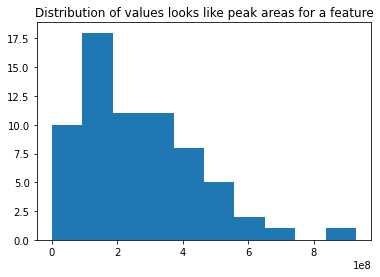

In [7]:
import struct
# https://stackoverflow.com/questions/50107670/python-convert-8-byte-ieee754-number-to-float
l = []
for i in np.arange(0, len(a), 9):
    d = struct.unpack('d', a[i:i+8])[0]
    l.append(d)
#     print(i, d)
plt.hist(l)
plt.title('Distribution of values looks like peak areas for a feature')

### Do the PQF columns follow the same convention as Area (8 bytes, 1 separator byte)?
### What are the unique values in each PQF? 

In [8]:
# Modality, Jaddedness, FWHM2Base, ZigZagIndex
pqf = cur.execute(f'SELECT PQFZigZagIndex FROM {cmpd}').fetchone()[0] 
print(len(pqf))
s = set()
for i in np.arange(0, 603, 9):
    raw = pqf[i: i+8]
    val = struct.unpack('d', raw)[0]
    s.add(val)
    s.add(raw)
# [s.add(x) for x in pqf]
s

603


{0.0,
 0.00014751217291244972,
 0.0002359598334711016,
 0.00029000737197776175,
 0.00030862262190284247,
 0.00046801687285345095,
 0.0007759596915077421,
 0.0008897620506193199,
 0.0011470318790684718,
 0.001160524993541465,
 0.00181411874036842,
 0.0024265340610946638,
 1.3496442183639802e-05,
 2.231382513777258e-05,
 5.2511902581283965e-06,
 9.833605635908679e-05,
 b"\x9f\x0cNt\xdd'M?",
 b'3\xe4L*\xf7\xb8]?',
 b'W\xc6\xbf\xbf8mI?',
 b'\x00\x00\x00\x00\x00\x00\x00\x00',
 b'\x81\x9e\xb2)\x05\xac>?',
 b'\x83\xf7\x95\x958\xc7\x19?',
 b'\xa4"\xaa\xe3\xd8M\xec>',
 b'\xd5\x08\xe7/l\x06\xd6>',
 b'\xd9\xae/c\xd2e\xf7>',
 b'\xdd#\xb6\xea\xafU#?',
 b'\xea[\xa1-\x84\x013?',
 b'\xf3{`\x11\xd494?',
 b'\xf5M.9\x98\x03S?',
 b'f\xcb\x1d\x1a\x00\xcbR?',
 b'p\xdb-\x89\x7f\xed.?',
 b'}\xc7\xeb\x8d\xcf\xe0c?'}

In [9]:
struct.unpack('d', pqf[:8])

(0.0,)

# Parse a blob of a spectrum from `MassSpectrumItems` table

In [91]:
spec = open('../tests/binary_CD_spectrum.bin', 'rb').read()
spec

b'PK\x03\x04\x14\x00\x00\x00\x08\x00yyoT\xcf\xdf\xce\xf2\xbb(\x00\x00$\x9c\x00\x00\x16\x00\x00\x00spectrum_3138-3138.xml\x95}\xdbn$\xd7\x95\xe5\xfb\x00\xf3\x0f\x04\xdf\x1d<\xf7\x8bQ\xaa\x86G\xb2a\x01-Yc\xa9{z\xe6\x8d\xae\xca*q\x9aE\x16H\x96d\xf5\xd7\xcfZ\x91\xe7D\x9c\x1d\xdc\x9112`@\x95\x19\xdcy.\xfb\xb2\xf65\xde\xfc\xcb??\xdd_\xfdrzz\xbe{|\xf8\xea\xdaN\xe6\xfa_\xde\xfe\xf7\xff\xf6\xe6\xbb\xdb\xe7\xe7\x1f?\x9f\xde\xbd<}\xf9t\x85G\x1e\x9e\xff\xf8\xcf\xe7\xf7_]\xff\xfc\xf2\xf2\xf9\x8f77\xbf\xfe\xfa\xeb\xf4\xab\x9f\x1e\x9f>\xde8c\xec\xcd\x7f|\xf7\xaf?\xbe\xfb\xf9\xf4\xe9\xf6zy\xf8\xee\xf8\xe1?\xdc=<\xbf\xdc>\xbc;]\xe3\'\xaf\xae\xde\xfc\xf5t\xfb\xfe\xf44\xff7\xfe\xd5\x7f\xfe\xdbo\xde\xfa\x14RJon\x86\x8f\xdaC\xdf\x82\x02>8=\xbc|\x7f\xfb\xe9\xf4\xf6\x7f^\xfd\xf9\x9f\xb7\xef^\xee~9]\xfd\xf5/W\x7f{\xfa\xc7\xdd\xcb\xd3\xed\xe777\x9b\xc7\xda\x1f\x7fs\xfbr\xfb\xd3o\x9fOo\xbf\xc6\x17O\x8fw\xef\xdf\xdc,\x1f\xb5G\xfe\xf5\xf1\xd7\x1f\x1e\x9f\xef^p:o\xb1\xf877\xe3\x07\xed\x99\xbf\xde}\xfcy|\x08O\x89\x

## Parsing this mass spectrum blob is more difficult because the blob binary length varies between spectra
### Take a few examples of byte counts and try to find a common denominator

In [87]:
sizes = np.array([3000, 2830, 6283, 1830, 7471, 2055])
for offset in range(0, 200):
    offset_sizes = sizes - offset
    for denom in range(3, 100):
        remainders = []
        for size in offset_sizes:
            remainders.append(size % denom)
        if all(x == 0 for x in remainders):
            print(offset, denom, remainders)

In [30]:
test = [0, 0, 1]
if all(x == 0 for x in test):
    print('hi')

In [36]:
for byte in spec:
    print(byte)

80
75
3
4
20
0
0
0
8
0
121
121
111
84
44
3
255
137
46
11
0
0
59
38
0
0
20
0
0
0
115
112
101
99
116
114
117
109
95
51
53
55
45
51
53
55
46
120
109
108
149
89
93
115
219
184
21
125
239
76
255
131
70
175
157
64
248
254
200
200
218
73
227
100
226
153
77
226
198
105
187
237
27
99
211
14
187
50
233
161
100
39
217
95
223
3
18
36
1
10
146
55
111
54
8
94
94
220
143
115
206
133
214
191
124
191
223
46
158
202
118
87
53
245
217
146
17
186
252
101
243
215
191
172
223
23
187
221
213
67
121
189
111
31
239
23
216
82
239
94
126
223
221
156
45
191
238
247
15
47
87
171
111
223
190
145
111
130
52
237
221
138
83
202
86
191
189
255
245
234
250
107
121
95
44
199
205
213
243
155
95
84
245
110
95
212
215
229
18
159
92
44
214
239
202
226
166
108
187
191
241
223
240
249
139
243
141
208
204
90
181
94
69
75
97
211
5
44
96
161
172
247
31
138
251
114
243
143
197
155
239
197
245
190
122
42
23
239
222
46
62
182
95
170
125
91
60
172
87
179
109
225
229
243
98
95
124
254
241
80
110
94
227
65
219
84
55
235
213
184
20
182


# There is a common sequence that appears in the binary: 

`spectrum XXXX - XXXX.xml` close to beginning 

and `.... [lots of periods] spectrum XXXX-XXXX.xmlPK`



In [39]:
0x2e# 0x78 0x6d 0x6c

46

In [88]:
for chunk_size in range(3, 26):
    for subset in np.arange(0, 300, chunk_size):
        val = struct.unpack('d', raw)[0]

In [48]:
help(struct)

Help on module struct:

NAME
    struct

MODULE REFERENCE
    https://docs.python.org/3.7/library/struct
    
    The following documentation is automatically generated from the Python
    source files.  It may be incomplete, incorrect or include features that
    are considered implementation detail and may vary between Python
    implementations.  When in doubt, consult the module reference at the
    location listed above.

DESCRIPTION
    Functions to convert between Python values and C structs.
    Python bytes objects are used to hold the data representing the C struct
    and also as format strings (explained below) to describe the layout of data
    in the C struct.
    
    The optional first format char indicates byte order, size and alignment:
      @: native order, size & alignment (default)
      =: native order, std. size & alignment
      <: little-endian, std. size & alignment
      >: big-endian, std. size & alignment
      !: same as >
    
    The remaining chars ind

In [98]:
for start_pos in np.arange(0, 5555):
    chunk = spec[start_pos:start_pos+4]
    unpacked = struct.unpack('L', chunk)[0]
    print(unpacked)

67324752
335807307
1311747
5124
20
134217728
524288
2030045184
2037973000
1870231808
1416591737
3478417273
3754906735
3470774100
4073643983
3153252063
683406030
2669554
10427
603979816
2619604992
10232832
39972
369098908
1441792
5632
22
1929379840
1886584832
1701868288
1667592307
1952671088
1920230245
1970435171
1836413556
1601009010
861891957
825450349
858862431
942879027
758657841
858601523
825437496
858862381
942879027
775435057
2016294963
1836592696
1819113518
2506911096
2106944621
3682440556
1859878293
611244925
3609489115
2513904750
3851802404
4226127319
16508309
4076927973
267583739
68154112
3741585395
501154831
1008590596
4147912159
2348235805
1368127292
2857470967
2259308939
1200007761
2991031978
1639073670
23179847
755065266
1496121697
1666788609
2841860397
2074698585
2054924643
3866786729
2380692091
2928535162
3400437222
717926029
1898629806
2591107786
1167749418
373660273
1209419162
2521306693
1687570454
4117009992
3623183510
3487036772
1523570677
2438647767
3885062863
1156

3847511965
2749715551
849601876
1597154277
3898552995
1860722482
3027167327
4189351656
2834936942
3483957684
3318720761
868601768
1379124687
475149253
1595691571
727653458
4113260316
2113219423
3833460011
1894022645
4184925309
3153686756
2914777456
1454226425
2136387003
2910803629
3618471766
4191661439
1945753517
2205415895
981693433
2755298163
3768859267
1977656378
3832930468
988050912
1211819125
3427285732
2009876538
2809646152
3685185484
3889932151
803724199
1328539611
1380921319
1934774063
4000535119
1022260050
4198297203
3992599790
4243454524
4126993914
3925212397
3957978620
4226542069
805039081
1143995371
1782853627
4285154351
2147445316
260046698
1024425983
1027411839
2117942543
8273213
3925900861
4226416766
3791383040
4058119146
4008829435
3790533089
2783047409
1067835886
2218763745
998522789
423330879
219757444
1309481275
3008236825
1102269965
591508302
3038986675
3316982593
918926627
3812017589
3286447813
2881741622
4289446883
4177505219
3942186923
3672832255
2581261048
98316

2219110413
3783542000
2229371972
59040132
1979942113
3027633028
112489987
3758535798
2665481908
2426331142
445685472
3122303134
3082427024
297253402
672249786
170398135
2852792337
1453984296
2287381002
3599259306
2329315414
1233835656
1967753942
745884042
1177318729
2504404085
9782828
1308661062
3394109589
3989458432
552454734
841018826
1815224557
2557227552
4086852658
3539179628
4275237784
268358387
2333081298
1351290878
3981478671
1173180555
2588274000
3449439725
1590532677
1398721946
3595787981
1909871454
1450301011
4149637590
1375164017
3327260502
1673941495
3697526353
719086534
422239331
2853776092
2863274282
3299519001
2680466090
1084212394
3477118916
3301916831
381996864
2232861903
8722116
83920150
671416453
1965556992
3245680645
3619779880
567787893
237098945
4161675735
1593314849
3177117710
1337810680
3092233566
146296765
1342748751
877660344
3241431048
1975596112
1433780532
156595649
2735297909
1436748117
3965035273
3740030371
1507781717
2858016492
3081394654
28813913
1678847

2827686124
61377296
235120779
3507356584
1506872835
2723795214
1621252561
526426713
2971623586
2041651040
2927210783
430864817
1612295801
2673875374
1201627161
726114144
3458942879
1926114119
678612523
4113068750
1375021170
1431434536
3713356277
1558009169
140303701
1342725341
2622490716
1771851784
376020048
471230876
2115769961
2340297750
1233878556
843680638
573720971
857879113
2553487922
1603810082
2103416883
461201304
1276869983
2018253693
3682094107
1524332620
458939256
1260083931
3494583130
198200091
3037450315
3266644944
1757590795
3295199925
600074434
1730397288
694625220
3458819875
3201182055
2948517417
1840234190
2171449278
1602317743
2338292077
327901057
1326680927
38736779
184700691
2970288719
884017922
1681174795
962868401
1245275188
2504669540
2811578937
413635914
1629005717
727783591
3039519000
1706371937
1147516203
1648649653
1231176805
1615422020
2422229346
1032872009
1463652448
1196899728
2001164093
2658617175
60716871
1963171447
1014301598
2419881219
1771060341
13323

3729019304
3453895761
2160975428
1233178078
3578364109
2480228736
1284756809
3561788373
1372867731
3176256588
3636285908
3671637329
1541068989
173791960
1510628314
2908359259
3131922954
1689955674
3982801581
1760388282
1802038628
4000016621
3689835368
2816208491
3601325038
651601883
3290879655
1019487958
3225207846
1388330180
3864182844
3571864256
685041234
4163425510
1895311572
1618016296
979398904
2704957552
1386297952
38969658
3355595425
3033006674
1018480642
1211937992
1648901300
375539772
1544970824
3596359266
1523997718
56284764
1375951574
4132569946
1895191043
3564172882
248803574
2920207472
3450736340
2530061838
3784756654
4276197069
1191109014
38207201
3724691198
249430598
4212055554
2784693982
77986574
2516887035
177603749
1628083716
358681238
756375818
4113372513
989146389
859501869
489896693
2904372026
3702332723
1121758493
1094900909
2168537820
1350648130
3394273601
3402256513
3402287696
4157262538
821545674
137426890
2802331895
2057766960
276473608
2567994023
630788218
42

In [42]:
spec[2]

3

In [44]:
for x in np.arange(0, 300, 4):
    print(spec[x:x+4])

b'PK\x03\x04'
b'\x14\x00\x00\x00'
b'\x08\x00yy'
b'oT,\x03'
b'\xff\x89.\x0b'
b'\x00\x00;&'
b'\x00\x00\x14\x00'
b'\x00\x00sp'
b'ectr'
b'um_3'
b'57-3'
b'57.x'
b'ml\x95Y'
b']s\xdb\xb8'
b'\x15}\xefL'
b'\xff\x83F\xaf'
b'\x9d@\xf8\xfe'
b'\xc8\xc8\xdaI'
b'\xe3d\xe2\x99'
b'M\xe2\xc6i'
b'\xbb\xed\x1bc'
b'\xd3\x0e\xbb2'
b"\xe9\xa1d'"
b'\xd9_\xdf\x03'
b'\x12$\x01\n'
b'\x927o6'
b'\x08^^\xdc'
b'\x8fs\xce\x85'
b'\xd6\xbf|\xbf'
b'\xdf.\x9e\xca'
b'vW5\xf5'
b'\xd9\x92\x11\xba'
b'\xfce\xf3\xd7'
b'\xbf\xac\xdf\x17'
b'\xbb\xdd\xd5C'
b'y\xbdo\x1f'
b'\xef\x17\xd8R'
b'\xef^~\xdf'
b'\xdd\x9c-\xbf'
b'\xee\xf7\x0f/'
b'W\xabo\xdf'
b'\xbe\x91o\x82'
b'4\xed\xdd\x8a'
b'S\xcaV\xbf'
b'\xbd\xff\xf5\xea'
b'\xfaky_'
b',\xc7\xcd\xd5'
b'\xf3\x9b_T'
b'\xf5n_\xd4'
b'\xd7\xe5\x12\x9f'
b'\\,\xd6\xef'
b'\xca\xe2\xa6l'
b'\xbb\xbf\xf1\xdf'
b'\xf0\xf9\x8b\xf3'
b'\x8d\xd0\xccZ'
b'\xb5^EK'
b'a\xd3\x05,'
b'`\xa1\xac\xf7'
b'\x1f\x8a\xfbr'
b'\xf3\x8f\xc5\x9b'
b'\xef\xc5\xf5\xbe'
b'z*\x17\xef'
b'\xde.>\xb6'
b'_\xaa}['
b'<\xacW\xb3'
b'm\